# Fine Tuning DistilBERT, MobileBERT and TinyBERT for Fake News Detection

## Text Classification Architecture

- Text classification is one of the most common tasks in NLP; it can be used for a broad range of applications, such as tagging customer feedback into categories or routing support tickets according to their language.

- smam classification, sentiment classification, toxic comment, emotion classification etc.


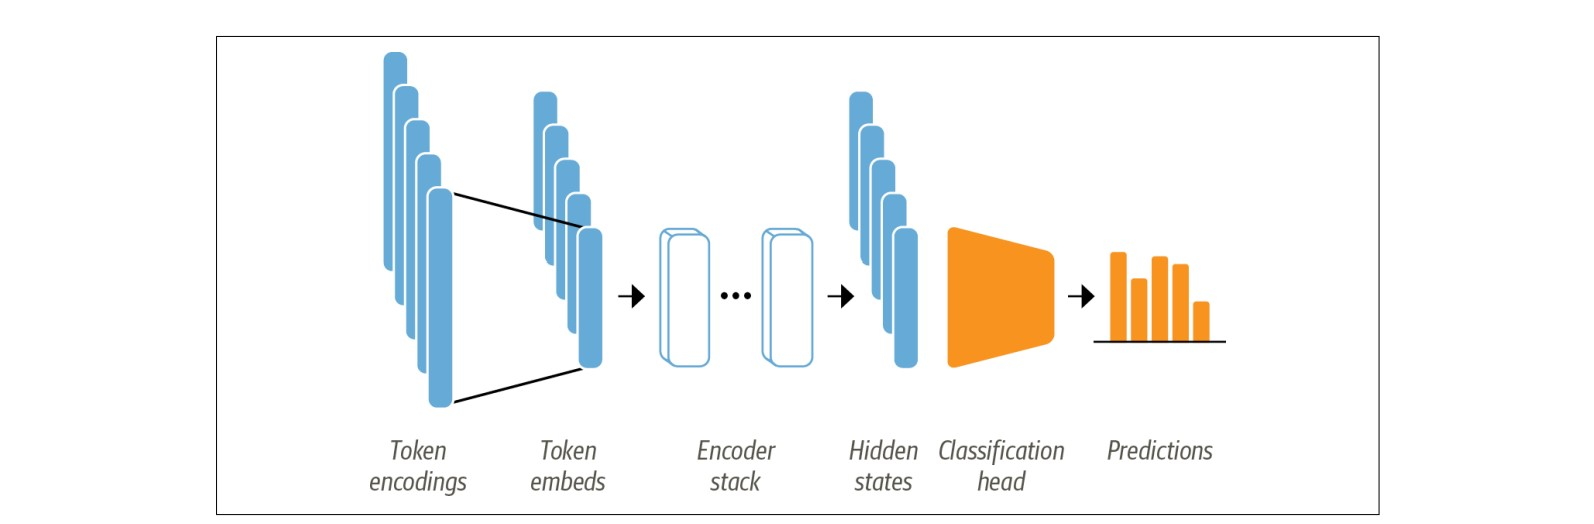

In [1]:
# !pip install -U transformers
# !pip install -U accelerate
# !pip install -U datasets
# !pip install -U bertviz
# !pip install -U umap-learn
# !pip install seaborn --upgrade

# !pip install -U openpyxl

# Don't do in production. Doing now to keep output clean for understanding
import warnings
warnings.filterwarnings('ignore')

In [2]:
import  pandas as pd
df = pd.read_excel("fake_news.xlsx")

In [3]:
df

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [4]:
df.isnull().sum()
df = df.dropna()

In [5]:
df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [6]:
df.shape

df['label'].value_counts()
#1- unreliable 
#0- reliable

label
0    10361
1     7920
Name: count, dtype: int64

# Data Analysis


In [ ]:
import matplotlib.pyplot as plt
# import seaborn as sns

Text(0.5, 1.0, 'Frequency of Classes')

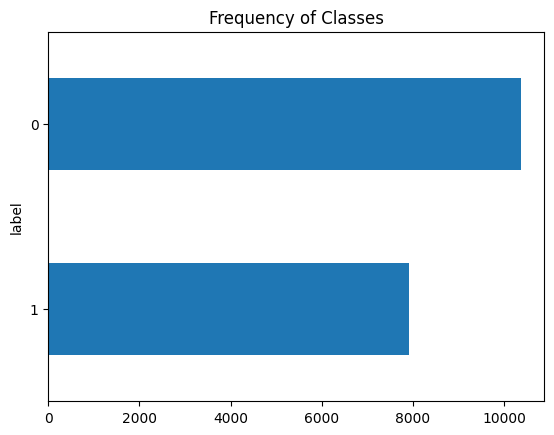

In [8]:
label_counts = df['label'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")

In [9]:
df

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


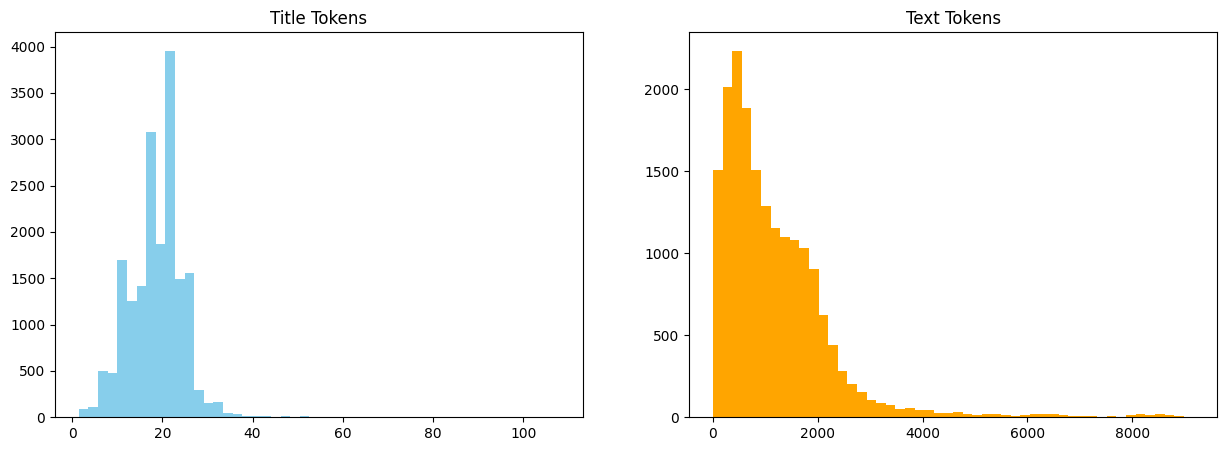

In [10]:
# 1.5 tokens per word on average
df['title_tokens'] = df['title'].apply(lambda x: len(x.split())*1.5)
df['text_tokens'] = df['text'].apply(lambda x: len(x.split())*1.5)


fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].hist(df['title_tokens'], bins=50, color = 'skyblue')
ax[0].set_title("Title Tokens")

ax[1].hist(df['text_tokens'], bins=50, color = 'orange')
ax[1].set_title("Text Tokens")

plt.show()

## Data Loader and Train Test Split

In [11]:
from sklearn.model_selection import train_test_split

# 70% for training, 20% test, 10% validation
train, test = train_test_split(df, test_size=0.3, stratify=df['label'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label'])

train.shape, test.shape, validation.shape, df.shape



((12796, 7), (3656, 7), (1829, 7), (18281, 7))

In [ ]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {
        "train": Dataset.from_pandas(train, preserve_index=False),
        "test": Dataset.from_pandas(test, preserve_index=False),
        "validation": Dataset.from_pandas(validation, preserve_index=False)
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 1829
    })
})

In [13]:
from transformers import AutoTokenizer

# Use one tokenizer to encode the dataset format
base_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(batch):
    return base_tokenizer(
        batch["title"],
        padding="max_length",
        truncation=True
    )

encoded_dataset = dataset.map(
    tokenize_function,
    batched=True
)

# Very important for Trainer
encoded_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

encoded_dataset


Map: 100%|██████████| 1829/1829 [00:00<00:00, 2583.27 examples/s]


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1829
    })
})

## Data Tokenization

In [14]:
from transformers import AutoTokenizer

text = "The things needs to be sudied thoroughly"

model_ckpt = "distilbert-base-uncased"
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
distilbert_tokens = distilbert_tokenizer.tokenize(text)

model_ckpt = "google/mobilebert-uncased"
mobilebert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
mobilebert_tokens = mobilebert_tokenizer.tokenize(text)

model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"
tinybert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tinybert_tokens = tinybert_tokenizer.tokenize(text)


In [15]:
distilbert_tokenizer, mobilebert_tokenizer, tinybert_tokenizer

(BertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 }
 ),
 BertTokenizer(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_length=1000000000000000019884624838656, padding_side='right', truncation_side='r

In [16]:
def tokenize(batch):
    temp = distilbert_tokenizer(batch['title'], padding=True, truncation=True)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 19169, 28208, 9274, 3992, 2005, 28879, 4747, 1521, 3909, 2482, 1521, 2622, 1011, 7987, 20175, 8237, 2102, 102], [101, 3782, 25840, 2203, 5668, 2229, 10454, 14233, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [17]:
encoded_dataset = dataset.map(tokenize, batch_size=None, batched=True)

Map: 100%|██████████| 1829/1829 [00:00<00:00, 12118.47 examples/s]


# Model Building

In [18]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch

label2id = {"Real": 0, "Fake": 1}
id2label = {0:"Real", 1:"Fake"}

model_ckpt = "distilbert-base-uncased"
# model_ckpt = "google/mobilebert-uncased"
# model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"


num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)




Loading weights: 100%|██████████| 100/100 [00:00<00:00, 289.11it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [19]:
model.config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": null,
  "dim": 768,
  "dropout": 0.1,
  "dtype": "float32",
  "eos_token_id": null,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Real",
    "1": "Fake"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Fake": 1,
    "Real": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "tie_word_embeddings": true,
  "transformers_version": "5.0.0",
  "vocab_size": 30522
}

# Fine tuninng

- `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs

- The first thing we need is a pretrained BERT-like model.
- The only slight modification is that we use the `AutoModelForSequenceClassification` model instead of AutoModel.
- The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model.

# Evaluator

https://huggingface.co/docs/transformers/v4.42.0/en/tasks/sequence_classification#evaluate

In [20]:
# Build compute metrics function
# !pip install evaluate
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [21]:
from transformers import TrainingArguments

batch_size = 32
training_dir = "train_dir"

training_args = TrainingArguments(
                                  output_dir=training_dir,
                                #   overwrite_output_dir = True,
                                  num_train_epochs = 2,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  eval_strategy = 'epoch'

)



In [22]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics_evaluate,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    processing_class=distilbert_tokenizer
)

In [23]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU")


CUDA available: True
Device count: 1
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


In [24]:
# trainer.train()


## Model Evaluation

In [25]:
preds_output = trainer.predict(encoded_dataset['test'])


In [26]:
preds_output.metrics

{'test_loss': 0.6833372116088867,
 'test_model_preparation_time': 0.0031,
 'test_accuracy': 0.5667396061269147,
 'test_runtime': 9.6248,
 'test_samples_per_second': 379.853,
 'test_steps_per_second': 47.482}

In [27]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = encoded_dataset['test'][:]['label']

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=list(label2id)))

              precision    recall  f1-score   support

        Real       0.57      1.00      0.72      2072
        Fake       0.00      0.00      0.00      1584

    accuracy                           0.57      3656
   macro avg       0.28      0.50      0.36      3656
weighted avg       0.32      0.57      0.41      3656



## Benchmarking

In [29]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [32]:
model_dict = {
    "bert-base": "bert-base-uncased",
    "distilbert": "distilbert-base-uncased",
    "mobilebert": "google/mobilebert-uncased",
    "tinybert": "huawei-noah/TinyBERT_General_4L_312D"
}

def train_model(model_name):
    model_ckpt = model_dict[model_name]

    # Load tokenizer (only needed for Trainer logging / decoding)
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

    # Load config with labels
    config = AutoConfig.from_pretrained(
        model_ckpt,
        label2id=label2id,
        id2label=id2label
    )

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_ckpt,
        config=config
    ).to(device)

    # Create unique training args per model (important!)
    training_args = TrainingArguments(
        output_dir=f"./results_{model_name}",
        num_train_epochs=2,
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        weight_decay=0.01,
        eval_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="no",
        report_to="none",
        fp16=True if device.type == "cuda" else False  # automatic speed boost
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=encoded_dataset['train'],
        eval_dataset=encoded_dataset['validation'],
        # tokenizer=tokenizer
    )

    trainer.train()

    preds = trainer.predict(encoded_dataset['test'])

    return preds.metrics


import time
model_performance = {}
for model_name in model_dict:
    print("\n\n")
    print("Training Model: ", model_name)

    start = time.time()
    result = train_model(model_name)
    end = time.time()
    
    model_performance[model_name] = {model_name:result, "time taken": end-start}




Training Model:  bert-base


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 519.74it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those pa

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.185850,0.117158,0.960087,0.960108
2,0.084730,0.123551,0.958447,0.958422





Training Model:  distilbert


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 540.68it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.190787,0.114315,0.956807,0.956797
2,0.083917,0.123068,0.958447,0.958428





Training Model:  mobilebert


Loading weights: 100%|██████████| 1111/1111 [00:03<00:00, 356.31it/s, Materializing param=mobilebert.encoder.layer.23.output.dense.weight]                  
MobileBertForSequenceClassification LOAD REPORT from: google/mobilebert-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
mobilebert.embeddings.position_ids         | UNEXPECTED | 
cls.predictions.dense.weight               | UNEXPECTED

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.000000,nan,0.566976,0.410296
2,0.000000,nan,0.566976,0.410296





Training Model:  tinybert


Loading weights: 100%|██████████| 71/71 [00:00<00:00, 867.28it/s, Materializing param=bert.pooler.dense.weight]                              
BertForSequenceClassification LOAD REPORT from: huawei-noah/TinyBERT_General_4L_312D
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
fit_denses.{0, 1, 2, 3, 4}.bias            | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
fit_denses.{0, 1, 2, 3, 4}.weight          | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classi

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.309069,0.217069,0.907053,0.906487
2,0.173745,0.173324,0.928376,0.928202


In [33]:
model_performance

{'bert-base': {'bert-base': {'test_loss': 0.12212392687797546,
   'test_accuracy': 0.9545951859956237,
   'test_f1': 0.9545336422544121,
   'test_runtime': 6.1902,
   'test_samples_per_second': 590.606,
   'test_steps_per_second': 18.578},
  'time taken': 211.77831625938416},
 'distilbert': {'distilbert': {'test_loss': 0.11342479288578033,
   'test_accuracy': 0.9565098468271335,
   'test_f1': 0.9564813704249652,
   'test_runtime': 3.7122,
   'test_samples_per_second': 984.867,
   'test_steps_per_second': 30.979},
  'time taken': 116.8797447681427},
 'mobilebert': {'mobilebert': {'test_loss': nan,
   'test_accuracy': 0.5667396061269147,
   'test_f1': 0.41001552510299133,
   'test_runtime': 15.0887,
   'test_samples_per_second': 242.3,
   'test_steps_per_second': 7.622},
  'time taken': 460.05050468444824},
 'tinybert': {'tinybert': {'test_loss': 0.16299359500408173,
   'test_accuracy': 0.9335339168490153,
   'test_f1': 0.9334237587908445,
   'test_runtime': 2.5348,
   'test_samples_per_

# Model Load and Save

In [34]:
trainer.save_model("fake_news")

Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


In [35]:
from transformers import pipeline

classifier = pipeline('text-classification', model= 'fake_news')


Loading weights: 100%|██████████| 104/104 [00:00<00:00, 460.23it/s, Materializing param=pre_classifier.weight]                                  


In [39]:
classifier("Aliens are real")

[{'label': 'Real', 'score': 0.5156161785125732}]